# Health Score

This Notebook presents the process used to compute the health score associated to recipes according to their nutritional information. 

In [1]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pylab as pl
from scipy.sparse import lil_matrix
from util import *
%matplotlib inline

In [2]:
#Get all recipes
recipes = [f.path.split("/")[1] for f in os.scandir("recipe_data/") if f.is_dir() ]    
print(recipes[:10])
print("Nb of recipes: " + str(len(recipes)))

['229804', '245348', '25093', '14930', '257743', '255991', '236394', '13148', '18454', '215435']
Nb of recipes: 44069


In [3]:
def getRecipeNutrition(recipe_id):
    directory = 'recipe_data/' + recipe_id + "/"
    fname = directory + "nutrition.json"
    if os.path.isfile(fname) == False :
        return False
    
    with open('recipe_data/' + recipe_id + "/nutrition.json", 'r') as infile:
        nutrition = json.load(infile)['nutrition']
        
    return nutrition

In [4]:
def getRecipeFacts(recipe_id):
    nutrition = getRecipeNutrition(recipe_id)
    facts_list = ['sodium', 'saturatedFat', 'fat', 'sugars']
    facts = {}
    for fact in facts_list:
        try:
            if nutrition[fact]["unit"] == 'g':
                facts[fact] = nutrition[fact]["amount"]
            else:
                if nutrition[fact]["unit"] == 'mg':
                    facts[fact] = nutrition[fact]["amount"] / 1000
                else:
                    if nutrition[fact]["unit"] == None:
                        facts[fact] = -1
                    else:
                        print("Can't get:")
                        print(nutrition[fact])
        except:
            facts[fact] = -1
    return facts

In [5]:
def getRecipeHealthScore(recipe_id):
    facts = getRecipeFacts(recipe_id)
    servingWeight = 200.0
    score = 0
    
    facts_list = ['sodium', 'saturatedFat', 'fat', 'sugars']
    for fact in facts_list:
        if facts[fact] == -1:
            score = -1
            return score
    
    if facts['fat'] < servingWeight/100 * 3:
        score += 1
    else:
        if facts['fat'] < servingWeight/100 * 17.5:
            score += 2
        else:
            score += 3
            
    if facts['saturatedFat'] < servingWeight/100 * 1.5:
        score += 1
    else:
        if facts['saturatedFat'] < servingWeight/100 * 5:
            score += 2
        else:
            score += 3    
            
    if facts['sugars'] < servingWeight/100 * 5:
        score += 1
    else:
        if facts['sugars'] < servingWeight/100 * 22.5:
            score += 2
        else:
            score += 3
            
    if facts['sodium'] < servingWeight/100 * 0.3:
        score += 1
    else:
        if facts['sodium'] < servingWeight/100 * 1.5:
            score += 2
        else:
            score += 3
    
    return score

In [194]:
for recipe_id in recipes: 
    score = getRecipeHealthScore(recipe_id)
    jsonScore = {}
    jsonScore["score"] = score
    with open('recipe_data/' + recipe_id + "/healthscore.json", 'w') as outfile:
        json.dump(jsonScore, outfile)

# Distribution of recipes healthiness

In [6]:
healthScores = []
for recipe_id in recipes:
    with open('recipe_data/' + recipe_id + "/healthscore.json", 'r') as infile:
        healthScores.append(json.load(infile)["score"])

In [7]:
from collections import Counter
count = Counter(healthScores)
healthData = []
for i in range(4, 13):
    healthData.append(count[i])

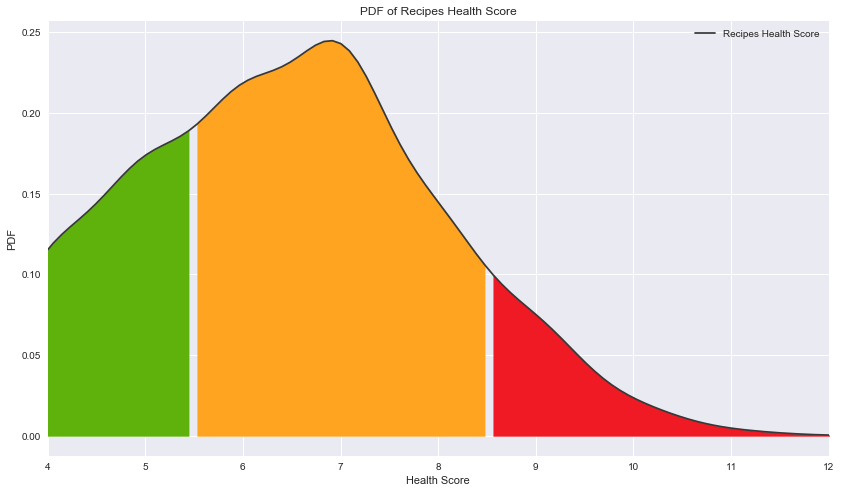

In [12]:
data = pd.Series(list(filter(lambda x: x >= 4,healthScores)))
data.name = "Recipes Health Score"
plotHealthHistogram(data, "PDF of Recipes Health Score")

## Health Score vs Popularity

In [14]:
with open("data/madeRecipeUsers.json", "r") as file:
    recipeUsers = json.loads(file.read())

In [15]:
'''recipeHealthPopularity = pd.DataFrame()
recipeHealthPopularity["Recipe"] = recipes
recipeHealthPopularity["HealthScore"] = healthScores
popularity = []
for recipe in recipes:
    if recipe in recipeUsers:
        popularity.append(len(recipeUsers[recipe]))
    else:
        popularity.append(0)
recipeHealthPopularity["Popularity"] = popularity

recipeHealthPopularity = recipeHealthPopularity[recipeHealthPopularity["HealthScore"] >= 4]
recipeHealthPopularity.to_csv("data/HealthPopularity.csv")
'''

recipeHealthPopularity = pd.read_csv("data/HealthPopularity.csv")

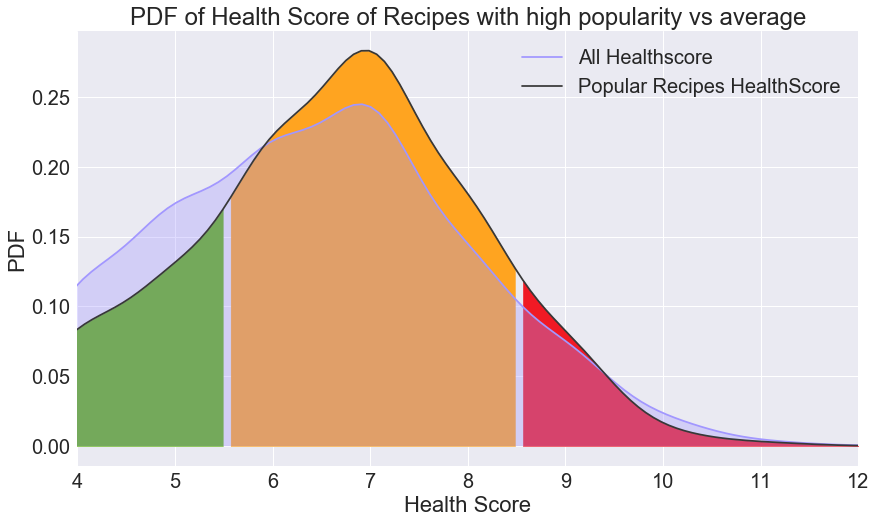

In [26]:
highPopRecipesHealth = recipeHealthPopularity[recipeHealthPopularity["Popularity"] >= 1000]["HealthScore"]
highPopRecipesHealth.name = "Popular Recipes HealthScore"
allHealthScore = recipeHealthPopularity["HealthScore"]
allHealthScore.name = "All Healthscore"
with sns.plotting_context("notebook", font_scale=2):
    plotHealthHistogram([highPopRecipesHealth, allHealthScore], "PDF of Health Score of Recipes with high popularity vs average")

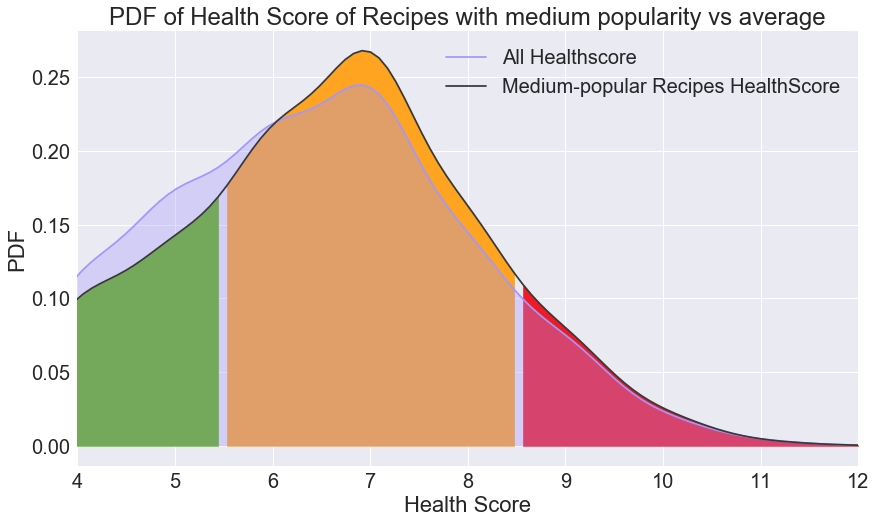

In [21]:
midPopRecipesHealth = recipeHealthPopularity[recipeHealthPopularity["Popularity"] < 1000]
midPopRecipesHealth = midPopRecipesHealth[midPopRecipesHealth["Popularity"] >= 100]["HealthScore"]
midPopRecipesHealth.name = "Medium-popular Recipes HealthScore"
with sns.plotting_context("notebook", font_scale=2):
    plotHealthHistogram([midPopRecipesHealth, allHealthScore], "PDF of Health Score of Recipes with medium popularity vs average")

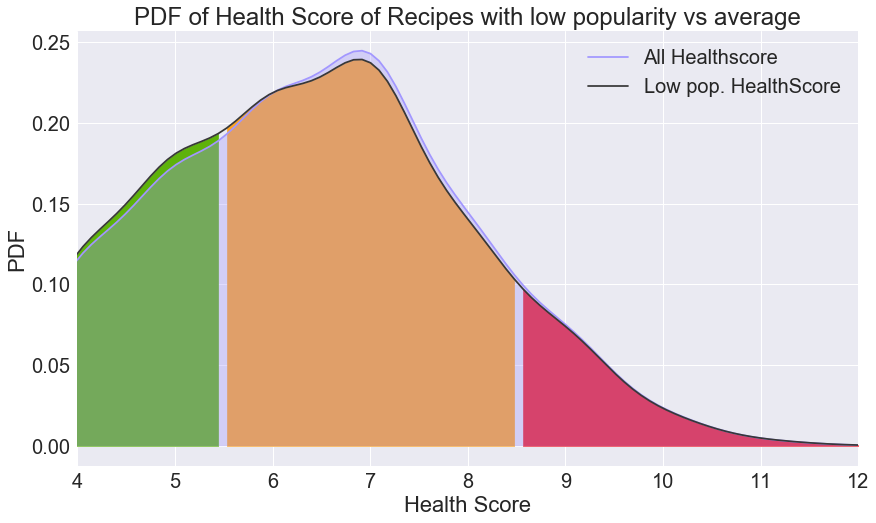

In [22]:
lowPopRecipesHealth = recipeHealthPopularity[recipeHealthPopularity["Popularity"] < 100]["HealthScore"]
lowPopRecipesHealth.name = "Low pop. HealthScore"
with sns.plotting_context("notebook", font_scale=2):
    plotHealthHistogram([lowPopRecipesHealth, allHealthScore], "PDF of Health Score of Recipes with low popularity vs average")